In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import json
import reprlib

In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
df = pd.read_csv('dataclean_uu_ite.csv')

In [4]:
temp_detokenize = []

def detokenize(text):
    text1 = text.replace(']','').replace('[','')
    arr = text1.replace('"','').replace("\'","").split(",")
    return(TreebankWordDetokenizer().detokenize(arr))

df['tweet'] = df['tweet'].astype('U').apply(detokenize)

In [5]:
df

,tweet
0,indonesia menyelamatkan abu janda terjerah...
1,makassar terkini jokowi revisi uu ite ro...
2,uu ite zaman pra sejarah orang pintar h...
3,uu ite pasal pasal karet dicabut pasal a...
4,revisi uu ite modus khawatir revisi buzz...
...,...
10036,didu jk dinsyamsuddin bedakan kritikhoaxny...
10037,jepang orang terlukakalo indonesia ngak b...
10038,wkwk ntaps ditegasin males giliran gini ...
10039,demokrat jokowi dikritik uu ite revisi


In [6]:
# Memanfaatkan nltk VADER untuk menggunakan leksikon kustom
sia1A, sia1B = SentimentIntensityAnalyzer(), SentimentIntensityAnalyzer()
# membersihkan leksikon VADER default karna default bahasa inggris
sia1A.lexicon.clear()
sia1B.lexicon.clear()


# Membaca leksikon InSet
# Leksikon InSet lexicon dibagi menjadi dua, yakni polaritas negatif dan polaritas positif;
# kita akan menggunakan nilai compound saja untuk memberi label pada suatu kalimat
with open('negative_uuite.json') as f:
    data1A = f.read()
with open('positive_uuite.json') as f:
    data1B = f.read()

# Mengubah leksikon sebagai dictionary
insetNeg = json.loads(data1A)
insetPos = json.loads(data1B)


# Update leksikon VADER yang sudah 'dimodifikasi'
sia1A.lexicon.update(insetNeg)
sia1B.lexicon.update(insetPos)


print(reprlib.repr(sia1A.lexicon))
print(reprlib.repr(sia1B.lexicon))


{'(barang) bekas': -4, '(olahraga) bokser': -5, '(tua) uzur': -3, 'Anda': -4, ...}
{'(hujan) gerimis': 1, '(warna) dadu': 3, 'Ahad': 3, 'Sri paduka': 4, ...}


In [13]:
def is_positive_inset(tweet):
    """True if tweet has positive compound sentiment, False otherwise."""
    return sia1A.polarity_scores(tweet)["compound"] + sia1B.polarity_scores(tweet)["compound"]

In [22]:
df2 = pd.DataFrame()
temp_df2 = []
temp_df3 = []

df2['tweet'] = df['tweet'].copy()

for tweet in df2['tweet']:
    if is_positive_inset(tweet) > 0:
        label = "Positif"
    elif is_positive_inset(tweet) == 0:
        label = "Netral"
    else:
        label = "Negatif"
    temp_df2.append([label])
    temp_df3.append([is_positive_inset(tweet)])
    
temp_df2 = pd.DataFrame(temp_df2, columns=['sentimen'])
temp_df3 = pd.DataFrame(temp_df3, columns=['compound'])
df2['sentimen'] = temp_df2['sentimen'].copy()
df2['compound'] = temp_df3['compound'].copy()
df2.reset_index(drop=True, inplace=True)
df2

,tweet,sentimen,compound
0,indonesia menyelamatkan abu janda terjerah...,Negatif,-0.0923
1,makassar terkini jokowi revisi uu ite ro...,Negatif,-0.0130
2,uu ite zaman pra sejarah orang pintar h...,Positif,0.0575
3,uu ite pasal pasal karet dicabut pasal a...,Negatif,-0.9989
4,revisi uu ite modus khawatir revisi buzz...,Negatif,-0.5324
...,...,...,...
10036,didu jk dinsyamsuddin bedakan kritikhoaxny...,Positif,0.0784
10037,jepang orang terlukakalo indonesia ngak b...,Negatif,-0.1060
10038,wkwk ntaps ditegasin males giliran gini ...,Positif,0.0067
10039,demokrat jokowi dikritik uu ite revisi,Negatif,-0.6124


In [23]:
df2.to_csv('revisi.csv', index=False)

In [9]:
print("Positif :",len(df2[df2.sentimen=="Positif"]), " tweet")
print("Negatif :",len(df2[df2.sentimen=="Negatif"]), " tweet")
print("Netral :",len(df2[df2.sentimen=="Netral"]), " tweet")

Positif : 1473  tweet
Negatif : 7592  tweet
Netral : 976  tweet


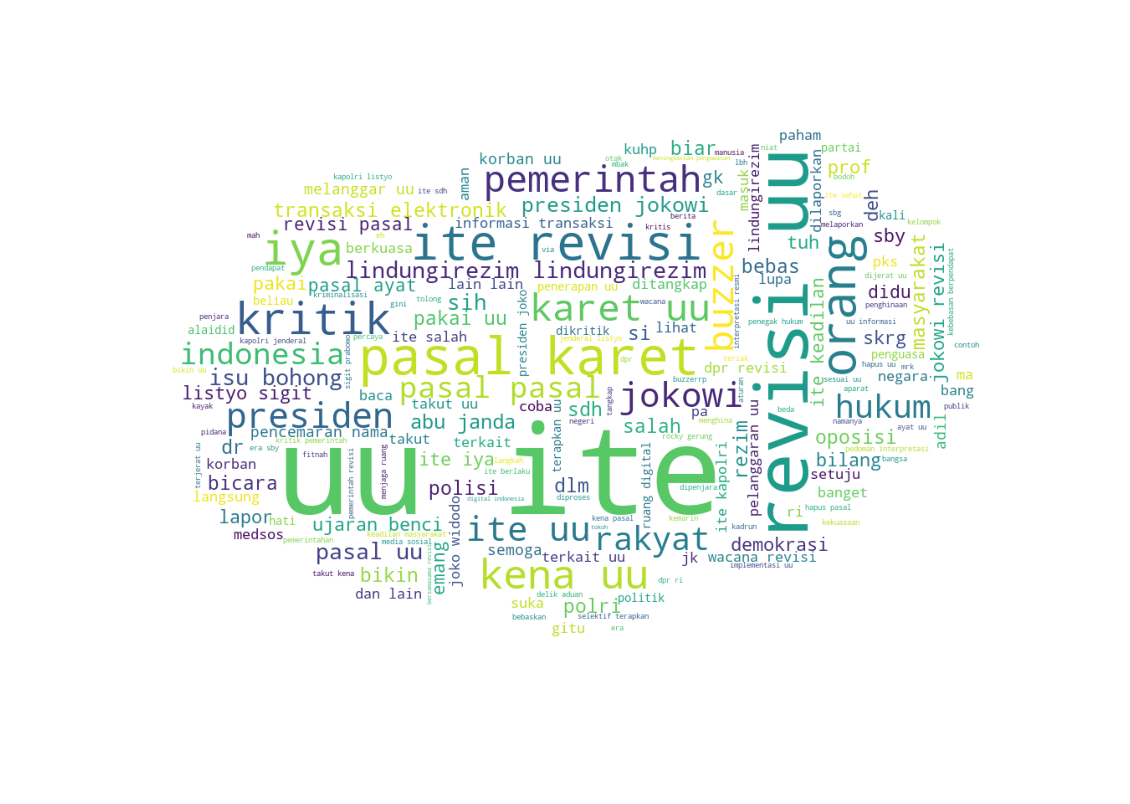

In [10]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(20, 20))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

text = df2['tweet'].astype('U')
mask = np.array(Image.open("cloud.png"))


# create wordcloud object
wc = WordCloud(background_color="white", 
                mask=mask)

# generate wordcloud
wc.generate(str(" ".join(text)))

plot_cloud(wc)

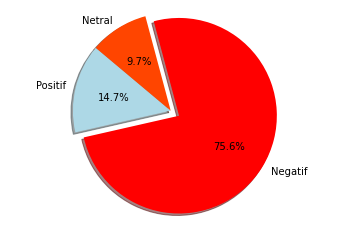

In [11]:
import matplotlib.pyplot as plt

labels = 'Positif', 'Negatif', 'Netral'
sizes = [len(df2[df2.sentimen=="Positif"]), len(df2[df2.sentimen=="Negatif"]), len(df2[df2.sentimen=="Netral"])]
colors = ['lightblue','red', 'orangered']
explode = (0, 0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [12]:
df2.to_csv('uuite_lexicon_nltk_sastrawi.csv', index=False)

In [23]:
# testing=df2.sample(n=int(len(df2)*5/100))
# testing

,tweet,sentimen
6504,sependapat jokowi politikus pdip bilang p...,Negatif
9486,ngk gitu langgar uu ite iya,Netral
8270,uu ite keadilan iya dpr bersamasama revi...,Negatif
1288,bicara revisi uu ite sdh terlambat masya...,Negatif
5423,didu jaman sby pakai uu ite kriminalisas...,Negatif
...,...,...
6378,revisi uu ite buzzer ditahan ditangkap w...,Negatif
2063,uu ite bab penjelasan pasal berhak menga...,Negatif
6815,kesempatan kepala negara pandangannya masy...,Negatif
5186,ujaran benci iya kena uu ite kya gini,Negatif


In [24]:
testing.to_csv('testing_uuite.csv', index=False)

In [13]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 30):
#     with open('all_uuite.txt', 'w') as f:
#         print(df2['tweet'].str.split(expand=True).stack().value_counts(), file=f)

In [14]:
lexicon_neg = df2[df2.sentimen=="Negatif"]
lexicon_neg.to_csv('uuite_lexicon_neg_sastrawi.csv', index=False)

In [15]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 30):
#     with open('neg_uuite.txt', 'w') as f:
#         print(lexicon_neg['tweet'].str.split(expand=True).stack().value_counts(), file=f)

In [16]:
lexicon_pos = df2[df2.sentimen=="Positif"]
lexicon_pos.to_csv('uuite_lexicon_positif_sastrawi.csv', index=False)

In [17]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 30):
#     with open('pos_uuite.txt', 'w') as f:
#         print(lexicon_pos['tweet'].str.split(expand=True).stack().value_counts(), file=f)

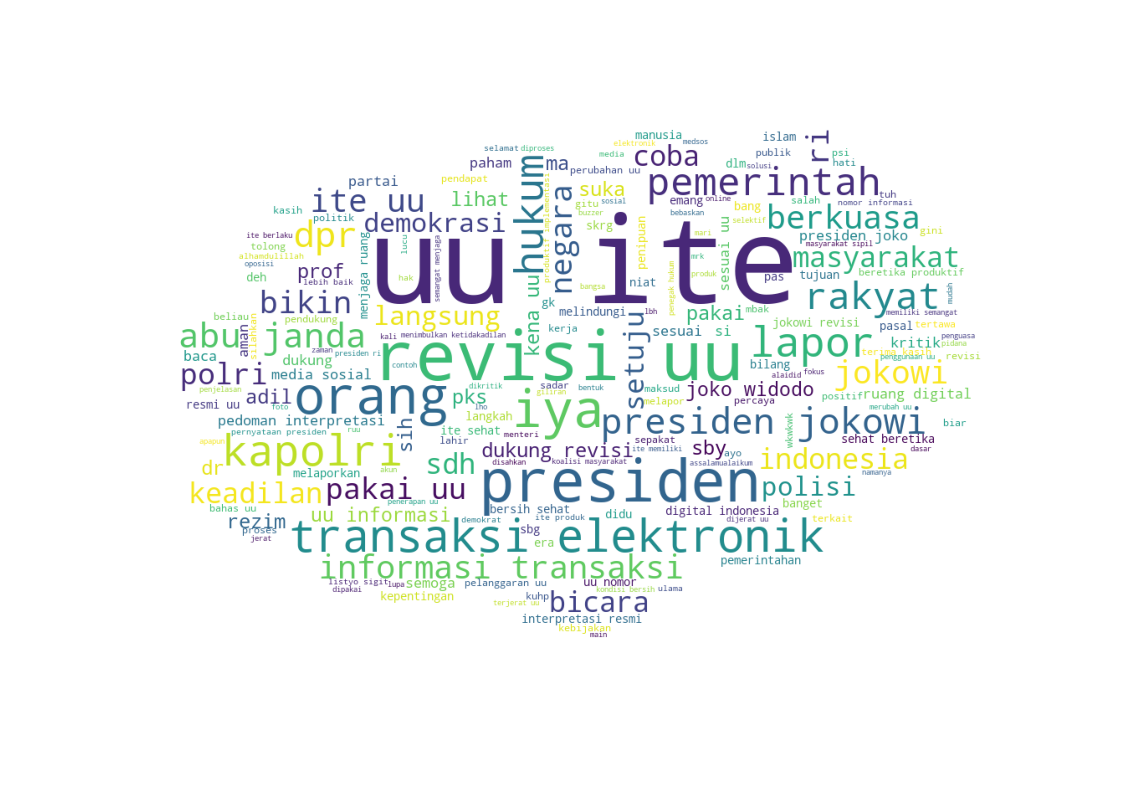

In [18]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(20, 20))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

text = lexicon_pos['tweet'].astype('U')
mask = np.array(Image.open("cloud.png"))


# create wordcloud object
wc = WordCloud(background_color="white", 
                mask=mask)

# generate wordcloud
wc.generate(str(" ".join(text)))

plot_cloud(wc)

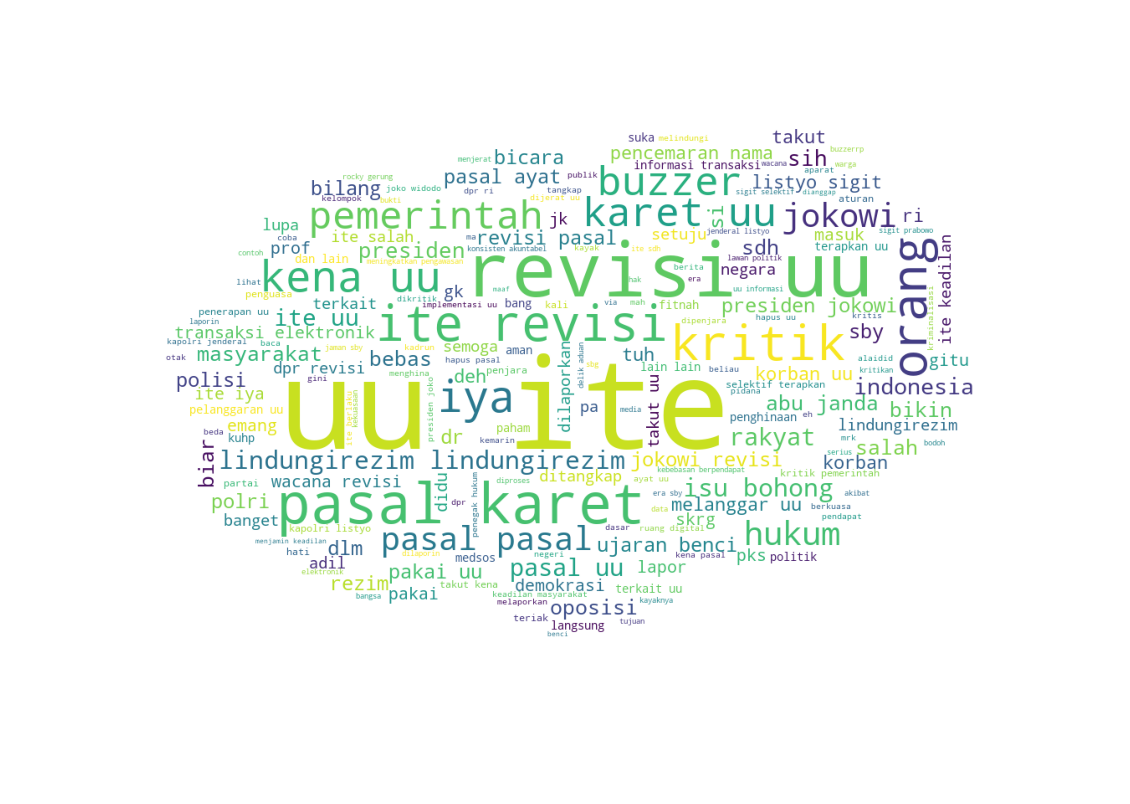

In [19]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(20, 20))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

text = lexicon_neg['tweet'].astype('U')
mask = np.array(Image.open("cloud.png"))


# create wordcloud object
wc = WordCloud(background_color="white", 
                mask=mask)

# generate wordcloud
wc.generate(str(" ".join(text)))

plot_cloud(wc)

In [20]:
# lexicon_0 = df2[df2.sentimen=="Netral"]
# lexicon_0.to_csv('uuite_lexicon_0_sastrawi.csv', index=False)

In [21]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 30):
#     with open('0_uuite.txt', 'w') as f:
#         print(lexicon_0['tweet'].str.split(expand=True).stack().value_counts(), file=f)

In [22]:
# def plot_cloud(wordcloud):
#     # Set figure size
#     plt.figure(figsize=(20, 20))
#     # Display image
#     plt.imshow(wordcloud) 
#     # No axis details
#     plt.axis("off")

# text = lexicon_0['tweet'].astype('U')
# mask = np.array(Image.open("cloud.png"))


# # create wordcloud object
# wc = WordCloud(background_color="white", 
#                 mask=mask)

# # generate wordcloud
# wc.generate(str(" ".join(text)))

# plot_cloud(wc)